## **Introduction**


* Long short term memory (LSTM) is a model that increases the memory of recurrent neural networks
* LSTMs are very widely used in Neural networks. Their effectiveness should be implemented to multiple sequence modelling problems in many application domains like video, NLP, geospatial, and time-series.


* For our scenario we are considering the time series because of the cause and effect relationship between the Forex market and the domestic equities

* Time-series data is a series of data values gathered over time interims, allowing us to trace differences over time. 
* Time-series data can trace progress over milliseconds, days, and years.

* Now we will implement LSTM on the stocks







In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler    #Importing MinMaxScaler for normlizing the dataset
from sklearn.metrics import mean_squared_error
from keras.models import Sequential               #Importing the Sequential module from Keras to run a sequential model
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

In [2]:
eurusd_df = pd.read_csv('/content/EURUSD.csv')
aapl_df = pd.read_csv('/content/AAPL_data.csv')
dlr_df = pd.read_csv('/content/DLR_data.csv')
xlnx_df = pd.read_csv('/content/XLNX_data.csv')
yum_df = pd.read_csv('/content/YUM_data.csv')

# **Feature Extraction**

*   I have performed a few feature extraction here. We take the dates alone from the overall date variable. 
* I have concatenated the data below to get the closing prices of each stock with the Date of the corresponding prices.
* The values in the EURUSD dataset don't have a header so I converted the inital top values which don't correspond to any values.




In [3]:
close_price_stock = pd.concat({
    eurusd_df.Date[len(eurusd_df)-1]:eurusd_df['Date'],
    eurusd_df.value[0]:eurusd_df['value'],
    aapl_df.Name[0]:aapl_df['close'],
    dlr_df.Name[0]:dlr_df['close'],
    xlnx_df.Name[0]:xlnx_df['close'], 
    yum_df.Name[0]:yum_df['close']
}, axis=1)

close_price_stock

,2018-02-07,1.3646,AAPL,DLR,XLNX,YUM
0,2013-02-01,1.3646,67.8542,65.40,37.51,65.30
1,2013-02-04,1.3513,68.5614,65.21,37.46,64.55
2,2013-02-05,1.3584,66.8428,65.69,37.58,64.75
3,2013-02-06,1.3519,66.7156,65.50,37.80,64.41
4,2013-02-07,1.3395,66.6556,65.37,38.44,63.89
...,...,...,...,...,...,...
1283,2018-02-01,1.2510,NaN,NaN,NaN,NaN
1284,2018-02-02,1.2463,NaN,NaN,NaN,NaN
1285,2018-02-05,1.2367,NaN,NaN,NaN,NaN
1286,2018-02-06,1.2377,NaN,NaN,NaN,NaN


In [4]:
close_price_stock = close_price_stock.rename(columns={'2018-02-07' : 'Date'})
close_price_stock = close_price_stock.rename(columns = {1.3646 : 'EURUSD'})
close_price_stock

,Date,EURUSD,AAPL,DLR,XLNX,YUM
0,2013-02-01,1.3646,67.8542,65.40,37.51,65.30
1,2013-02-04,1.3513,68.5614,65.21,37.46,64.55
2,2013-02-05,1.3584,66.8428,65.69,37.58,64.75
3,2013-02-06,1.3519,66.7156,65.50,37.80,64.41
4,2013-02-07,1.3395,66.6556,65.37,38.44,63.89
...,...,...,...,...,...,...
1283,2018-02-01,1.2510,NaN,NaN,NaN,NaN
1284,2018-02-02,1.2463,NaN,NaN,NaN,NaN
1285,2018-02-05,1.2367,NaN,NaN,NaN,NaN
1286,2018-02-06,1.2377,NaN,NaN,NaN,NaN


# **Plotting the Dataset**


*   Now I used matplotlib to visualize the available data and see how our price values in data are being displayed.
*   Matplotlib automatically changes the colours of the columns so that the data is easier to distinguish
* In the dataset since the value of the EURUSD is so small it looks like a line in the graph in comparison to the domestic equities



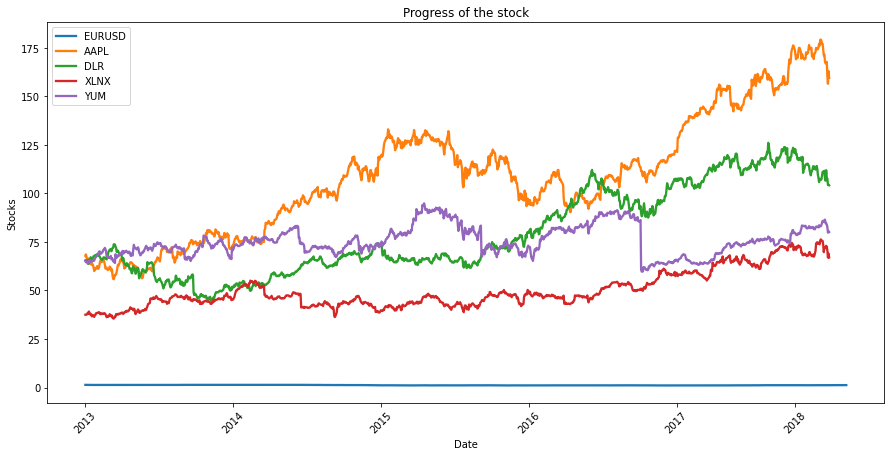

In [5]:
plt.figure(figsize=(15,7))

plt.plot(close_price_stock['EURUSD'], label='EURUSD', linewidth=2.3)
plt.plot(close_price_stock['AAPL'], label='AAPL', linewidth=2.3)
plt.plot(close_price_stock['DLR'], label='DLR', linewidth=2.3)
plt.plot(close_price_stock['XLNX'], label='XLNX', linewidth=2.3)
plt.plot(close_price_stock['YUM'], label='YUM', linewidth=2.3)

x_labels = [2013,2014,2015,2016,2017,2018]
plt.title('Progress of the stock')
plt.xticks([0,250,500,750,1000,1200],x_labels, rotation = 45)
plt.xlabel('Date')
plt.ylabel('Stocks')
plt.legend()
plt.show()

In [6]:
close_price_stock = close_price_stock.dropna()  # Dropping all the null values in the stock
close_price_stock

,Date,EURUSD,AAPL,DLR,XLNX,YUM
0,2013-02-01,1.3646,67.8542,65.40,37.51,65.30
1,2013-02-04,1.3513,68.5614,65.21,37.46,64.55
2,2013-02-05,1.3584,66.8428,65.69,37.58,64.75
3,2013-02-06,1.3519,66.7156,65.50,37.80,64.41
4,2013-02-07,1.3395,66.6556,65.37,38.44,63.89
...,...,...,...,...,...,...
1254,2017-12-22,1.1862,167.7800,107.98,72.49,83.98
1255,2017-12-25,1.1870,160.5000,107.71,70.64,82.63
1256,2017-12-26,1.1858,156.4900,104.33,66.97,79.80
1257,2017-12-27,1.1888,163.0300,104.50,68.99,80.58


# Calculating the percentage changes

* The data down bellow gives us the monthly percentage chnages in the stock to visualize whether there is a correlation between the stocks

In [ ]:
close_price_stock['EURUSD'] = eurusd_df['value'] - 1
close_price_stock['AAPL'] = aapl_df['close'] / aapl_df['open'] - 1
close_price_stock['DLR'] = dlr_df['close'] / dlr_df['open'] - 1
close_price_stock['XLNX'] = xlnx_df['close'] / xlnx_df['open'] - 1
close_price_stock['YUM'] = yum_df['close'] / yum_df['open'] - 1

In [8]:
close_price_stock

,Date,EURUSD,AAPL,DLR,XLNX,YUM
0,2013-02-01,0.3646,0.002068,0.000000,0.013784,0.025118
1,2013-02-04,0.3513,0.007198,-0.002905,0.000000,-0.009362
2,2013-02-05,0.3584,-0.024213,-0.004395,0.006158,0.002632
3,2013-02-06,0.3519,-0.000429,-0.005617,0.004518,-0.005558
4,2013-02-07,0.3395,0.004456,0.003377,0.022069,-0.005913
...,...,...,...,...,...,...
1254,2017-12-22,0.1862,0.003679,-0.035548,-0.003848,-0.003086
1255,2017-12-25,0.1870,-0.033133,0.009277,-0.016430,-0.015137
1256,2017-12-26,0.1858,-0.016405,-0.027226,-0.043832,-0.027659
1257,2017-12-27,0.1888,0.052961,0.011029,0.052479,0.028462


In [ ]:
close_price_stock['Date'] = pd.to_datetime(close_price_stock['Date'].apply(lambda x: x.split()[0])) 
close_price_stock.set_index('Date', drop=True, inplace=True) 

# **Data Pre-Processing**


*   We must pre-process this data before applying stock price using LSTM. 
* Transform the values in our data with help of the fit_transform function.
*  Min-max scaler is used for scaling the data so that we can bring all the price values to a common scale. 
* We then use 80 % data for training and the rest 20% for testing and assign them to separate variables.



In [ ]:
Ms = MinMaxScaler()
close_price_stock[close_price_stock.columns] = Ms.fit_transform(close_price_stock)

In [11]:
training_size = round(len(close_price_stock) * 0.80)

In [12]:
train_data = close_price_stock[:training_size]
test_data  = close_price_stock[training_size:]

# **Splitting the data into training and testing**

* I created a funtion here to split the data into training and testing sequentially

In [13]:
def create_sequence(dataset):
  sequences = []
  labels = []
  start_index = 0
  for stop_index in range(50, len(dataset)):
    sequences.append(dataset.iloc[start_index:stop_index])
    labels.append(dataset.iloc[stop_index])
    start_index += 1
  return np.array(sequences), np.array(labels)

In [14]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

# **Implementation of our LSTM model:**


*   We use two LSTM layers in our model and implement drop out in between for regularization. 
* The number of units assigned in the LSTM parameter is fifty. with a dropout of 10 %.
*  Mean squared error is the loss function for optimizing the problem with adam optimizer. 
* Mean absolute error is the metric used in our LSTM network as it is associated with time-series data.



In [15]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))
model.add(Dropout(0.1)) 
model.add(LSTM(units=50))
model.add(Dense(5))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 31,655
Trainable params: 31,655
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(train_seq, train_label, epochs=50,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/50
30/30 [==============================] - 8s 81ms/step - loss: 0.0623 - mean_absolute_error: 0.1850 - val_loss: 0.0098 - val_mean_absolute_error: 0.0746
Epoch 2/50
30/30 [==============================] - 1s 50ms/step - loss: 0.0089 - mean_absolute_error: 0.0693 - val_loss: 0.0071 - val_mean_absolute_error: 0.0588
Epoch 3/50
30/30 [==============================] - 2s 50ms/step - loss: 0.0082 - mean_absolute_error: 0.0657 - val_loss: 0.0071 - val_mean_absolute_error: 0.0587
Epoch 4/50
30/30 [==============================] - 2s 50ms/step - loss: 0.0082 - mean_absolute_error: 0.0657 - val_loss: 0.0067 - val_mean_absolute_error: 0.0558
Epoch 5/50
30/30 [==============================] - 2s 51ms/step - loss: 0.0083 - mean_absolute_error: 0.0661 - val_loss: 0.0068 - val_mean_absolute_error: 0.0572
Epoch 6/50
30/30 [==============================] - 1s 48ms/step - loss: 0.0082 - mean_absolute_error: 0.0656 - val_loss: 0.0070 - val_mean_absolute_error: 0.0578
Epoch 7/50
30/30 [====

In [17]:
test_predicted = model.predict(test_seq)

In [18]:
test_inverse_predicted = Ms.inverse_transform(test_predicted)

# **Visualization**
* After fitting the data with our model we use it for prediction.
*  We must use inverse transformation to get back the original value with the transformed function. 
* Now we can use this data to visualize the prediction.

In [19]:
close_slic_data = pd.concat(
    [close_price_stock.iloc[-202:].copy(),
     pd.DataFrame(test_inverse_predicted,
                  columns=['EURUSD_predicted','AAPL_predicted','DLR_predicted','XLNX_predicted','YUM_predicted'],
                  index = close_price_stock.iloc[-202:].index)], axis=1)

In [20]:
close_slic_data[['EURUSD_predicted','AAPL_predicted','DLR_predicted','XLNX_predicted','YUM_predicted']] = Ms.inverse_transform(close_slic_data[['EURUSD_predicted','AAPL_predicted','DLR_predicted','XLNX_predicted','YUM_predicted']])

In [21]:
close_slic_data.head()

,EURUSD,AAPL,DLR,XLNX,YUM,EURUSD_predicted,AAPL_predicted,DLR_predicted,XLNX_predicted,YUM_predicted
Date,,,,,,,,,,
2017-03-22,0.115374,0.424923,0.598519,0.595037,0.386276,0.064875,-0.066307,-0.085556,-0.067407,-0.044361
2017-03-23,0.111425,0.439073,0.533040,0.736756,0.486924,0.065552,-0.066290,-0.085566,-0.067400,-0.044351
2017-03-24,0.115656,0.460813,0.609915,0.544290,0.440726,0.066054,-0.066271,-0.085607,-0.067387,-0.044337
2017-03-27,0.134274,0.397036,0.573207,0.465539,0.393811,0.066686,-0.066273,-0.085607,-0.067394,-0.044330
2017-03-28,0.120169,0.426703,0.741805,0.714242,0.388205,0.067600,-0.066271,-0.085600,-0.067410,-0.044323


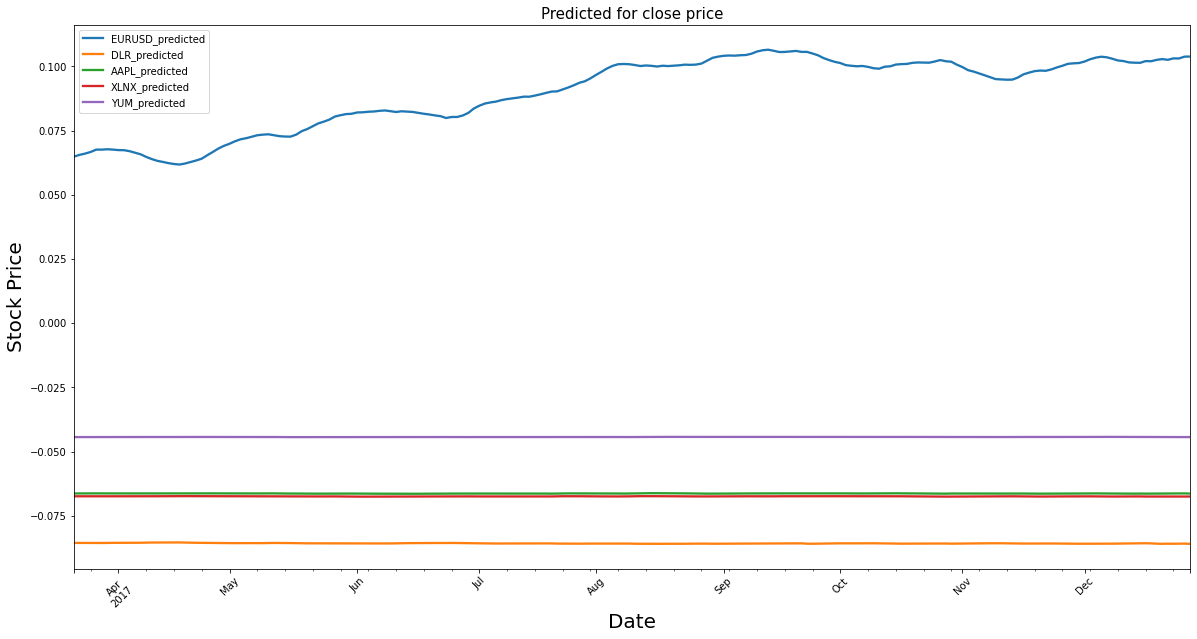

In [24]:
legend = ['EURUSD_predicted','DLR_predicted','AAPL_predicted','XLNX_predicted','YUM_predicted']
close_slic_data[legend].plot(figsize=(20,10),linewidth = 2.3)

plt.xticks(rotation=45)
plt.xlabel('Date',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Predicted for close price',size=15)
plt.show()

# **Conclusion**



*   From our analysis we can see that the forex market doesn't influence the domestic equities as all the values are pretty much constant whereas the value for the EURUSD is changing constantly while not affecting the stocks over a period of time
* From this we can infer that the claim was false.

